机器学习处理问题的常规步骤：

① 业务场景：了解业务场景和目标

② 数据准备：获取数据+认识数据

③ 数据处理：数据清洗、噪声数据处理、数据标准化、数据表示等

④ 特征工程：特征提取和特征选择

⑤ 模型选择：根据具体业务场景和数据量级选择具体模型

⑥ 模型调参：交叉验证、网格搜索等获取最佳模型参数

⑦ 模型分析：不同的评判标准loss function对结果的影响，模型评估等

⑧ 模型应用：模型保存、模型预测

# 1.业务场景  
Titanic - Machine Learning from Disaster
Start here! Predict survival on the Titanic and get familiar with ML basics

本次机器学习我们希望通过对泰坦尼克号灾难中乘客的相关属性描述，预测其是否在此次灾难中幸存，数据包含了test.csv和train.csv，其分别用于做测试和模型训练，而我们的目标其实很简单，尽可能让模型在测试数据上的评分更高，即尽量提升模型的准确性。

这是一个非常经典的二分类问题，我们需要对数据进行清洗，去掉一些噪声数据，然后选择适当的模型进行训练和评估，开始~

# 2.数据准备  
## 2.1 导入数据

In [33]:
# 导入数据分析常用库，该部分模块可用于数据集的分析和可视化
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# 导入数据
df_train = pd.read_csv("./titanic/train.csv")
df_test = pd.read_csv("./titanic/test.csv")

## 2.2 查看数据
特征说明：  
1、PassengerId：游客编码，唯一标识，对于模型没有实质作用特征  
2、Survived：是否幸存 0-No 1-Yes 即模型训练中的标签  
3、Pclass：船票等级  
4、Name：游客姓名，游客姓名本无实质意义，但其包含Mr，Mrs等信息，可以通过处理获取新的特征  
5、Sex：性别  
6、Age：年龄 连续值  
7、SibSp：泰坦尼克号上的兄弟姐妹/配偶数量  
8、parch：泰坦尼克号上的父母/孩子数量  
9、Ticket：票号  
10、Fare：船票价格  
11、Cabin：客舱号  
12、Embarked：出发港  

In [35]:
# 查看训练数据
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [36]:
# 分析数据集
df_train.info()

# 1、通过查看info信息发现，训练集有891个样本，其中Age、Cabin、Embarked有缺失项
# 2、其中Cabin空值太多，一般对于这种特征可以直接删除

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 2.3 分析数据

([<matplotlib.patches.Wedge at 0x7f847f4da950>,
 [Text(0.1896015698302508, -1.1849266832669034, '0'),
  Text(-0.18960145888940746, 1.1849267010186781, '1')],
 [Text(0.11850098114390677, -0.7405791770418146, '61.62%'),
  Text(-0.11850091180587968, 0.7405791881366739, '38.38%')])

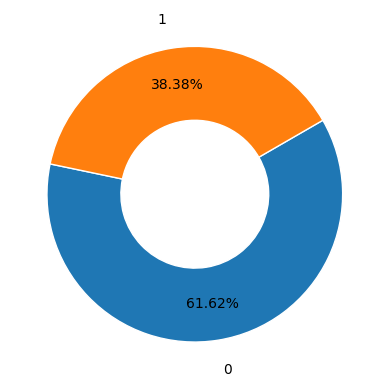

In [37]:
# 查看样本数据分布比例
plt.pie(x=np.bincount(df_train.Survived),
        labels=np.unique(df_train.Survived),
        #------autopct百分比格式 labeldistance类型距离中心长度，pctdistance百分比距离中心长度
        autopct='%.2f%%', labeldistance=1.2, pctdistance=0.75, 
        counterclock=False, startangle=30,  #------counterclock True顺时针 False逆时针 startangle开始角度
        wedgeprops={'width':0.5, 'edgecolor':'w'}, #------设置中心宽度，可以用来生成环图
        radius=1  #------半径
       )

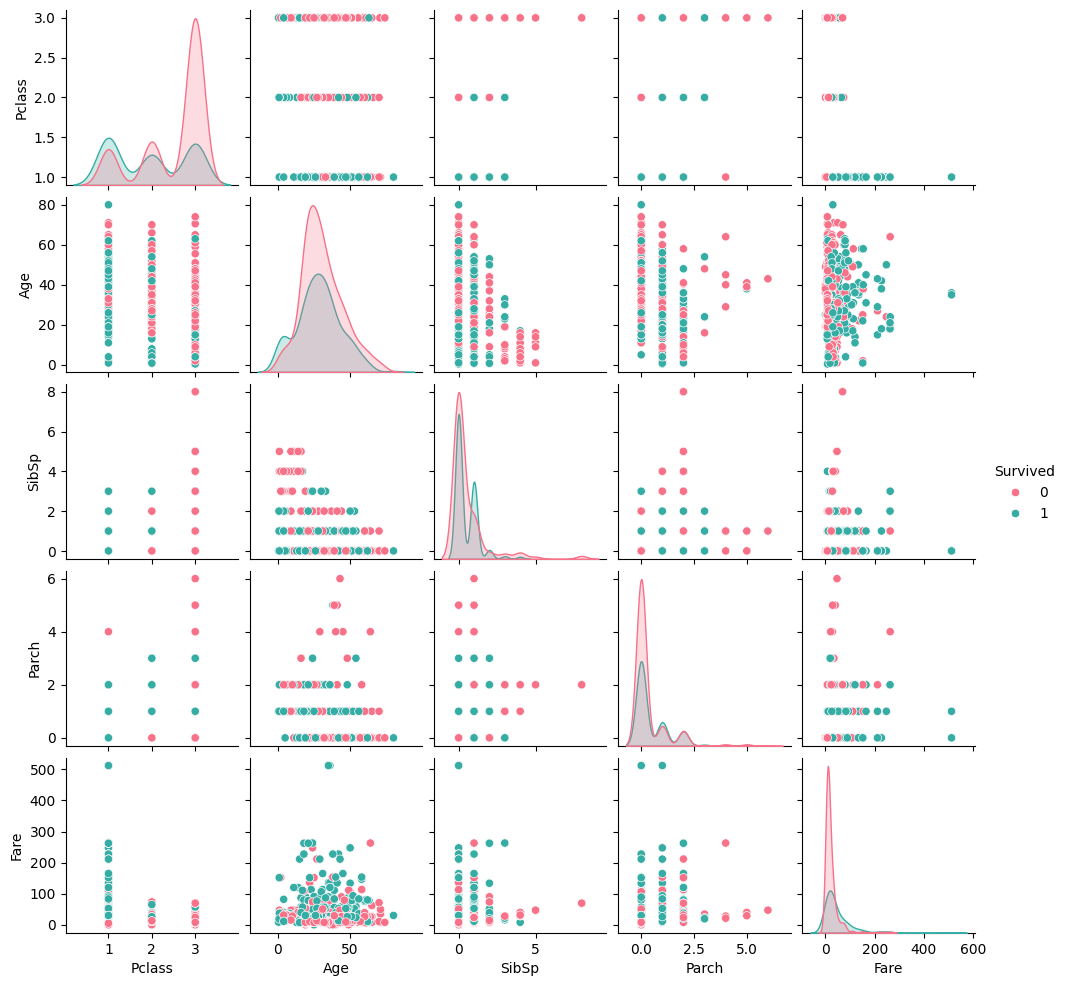

In [38]:
# 通过矩阵散点图查看数据特征之间的内在关系
sns.pairplot(df_train.drop(['PassengerId'], axis='columns'), 
             hue='Survived', kind='scatter', 
             palette='husl', height=2,
            )

In [39]:
# 查看Cabin特征分布
df_train[df_train.Cabin.notna()].Survived.value_counts()

Survived
1    136
0     68
Name: count, dtype: int64

In [40]:
# 查看Ticket相关信息
df_train[df_train.Ticket.str.isdigit()].Survived.value_counts()

Survived
0    407
1    254
Name: count, dtype: int64

In [41]:
# 查看Ticket相关信息
df_train[~df_train.Ticket.str.isdigit()].Survived.value_counts()

Survived
0    142
1     88
Name: count, dtype: int64

# 3.数据处理
数据处理分析：  
1、PassengerId为旅客编码，没有任何参考价值，可以直接删掉  
2、Cabin特征绝大部分为空，无法处理，且不为空的部分也没有实质规律，没有参考价值，可以直接删除  
3、Ticket为船票编号，本质上是否生还与其没有直接关系，直接删除  
4、Name为旅游名字，本质上是否生还与其没有直接关系，但我们可以从名字中获取更为明细的信息，例如Mis，Master等  

## 3.1 新增特征

In [42]:
# 顾客姓名虽然没有直接关系，但是其包含例如Dr，Mrs等，可以单出抽取出来作为一个特征
name_type = df_train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(name_type, df_train.Survived)

Survived,0,1
Name,,
Capt,1,0
Col,1,1
Countess,0,1
Don,1,0
Dr,4,3
Jonkheer,1,0
Lady,0,1
Major,1,1
Master,17,23


In [43]:
# 通过名字的属性我们增加name_type属性，并删除Name属性
df_train['name_type'] = name_type.map(lambda a:a if a in \
                                      ['Master', 'Miss', 'Mr', 'Mrs'] else 'Others')

## 3.2 删除无用属性

In [44]:
# 从对Ticket的分析中可以发现，数字编码船票和非数字编码船票似乎对于是否幸存没有帮助，我们可以将该属性剔除
df_train.drop(['Ticket'], axis='columns', inplace=True)

# 删除Cabin
df_train.drop('Cabin', axis='columns', inplace=True)

# 删除PassengerId
df_train.drop('PassengerId', axis='columns', inplace=True)

# 删除用户名字
df_train.drop(['Name'], axis='columns', inplace=True)

In [45]:
# 查看新的df
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,name_type
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


## 3.3 填补空值

In [46]:
# 填补空值-Age
age_mean = df_train.Age.mean()
age_std = df_train.Age.std()
age_nan_count = df_train[df_train.Age.isna()].Survived.count()

# 随机生成Age
df_train.fillna(value={'Age':np.random.randint(age_mean-age_std, age_mean+age_std)}, inplace=True)

In [47]:
# 查看Embarked分布情况
df_train.Embarked.value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [48]:
# 直接填充Embarked为其最多项S
df_train.fillna(value={'Embarked':'S'}, inplace=True)

In [49]:
# 重新查看df_train，确认填补Nan完成
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   Sex        891 non-null    object 
 3   Age        891 non-null    float64
 4   SibSp      891 non-null    int64  
 5   Parch      891 non-null    int64  
 6   Fare       891 non-null    float64
 7   Embarked   891 non-null    object 
 8   name_type  891 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


## 3.4 数据转换和编码

In [50]:
# 数据表示，One-hot编码，采用pandas的get_dummies函数
df_train = pd.get_dummies(df_train)

In [51]:
df_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,name_type_Master,name_type_Miss,name_type_Mr,name_type_Mrs,name_type_Others
0,0,3,22.0,1,0,7.2500,False,True,False,False,True,False,False,True,False,False
1,1,1,38.0,1,0,71.2833,True,False,True,False,False,False,False,False,True,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,True,False,True,False,False,False
3,1,1,35.0,1,0,53.1000,True,False,False,False,True,False,False,False,True,False
4,0,3,35.0,0,0,8.0500,False,True,False,False,True,False,False,True,False,False


## 3.5 数据拆分

In [52]:
# 生成机器学习所需格式的样本数据集
X = np.array(df_train.drop(['Survived'], axis='columns'))
y = np.array(df_train.Survived)

In [53]:
X.shape

(891, 15)

In [54]:
y.shape

(891,)

In [55]:
# 拆分训练集和测试集
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=3)

# 4.特征工程
特征工程是指在机器学习任务中对原始数据进行预处理和转换，以提取更有意义、更适合模型训练的特征的过程。它是构建高性能机器学习模型的关键步骤之一，可以帮助模型更好地理解数据，并提高模型的准确性和泛化能力。

本场景中特征较少，且通过前面的数据处理已经全部转换成数值，故无需单独做特征工程，接下来可以直接建模

# 5.模型选择
在选择模型中，理论上应该分析数据情况选择最优模型，但实际工作中起始直接判断是不现实的，最佳的方法是选择几种模型进行初步分析，大致了解一下哪个模型可能最佳，然后再精确调参获取最佳得分，在浅层机器学习中，ensemble模型往往效果更佳，例如随机森林、梯度提升、xgboost等，同时也可使使用线性模型进行验证，需要注意的是如果数据集较简单，knn、逻辑回归等简单模型或许也会得到较好的效果。

## 5.1 K-近邻模型

In [56]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

classifier_score = []

# 1、Knn算法
pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())
param_grids = {
    'kneighborsclassifier__n_neighbors':range(1, 10)
}
gridcv = GridSearchCV(estimator=pipe, param_grid=param_grids, cv=5).fit(X_train, y_train)
score = gridcv.score(X_test, y_test)
print('Best param:', gridcv.best_params_)
print('KNeighborsClassifier Score:', score.mean())
classifier_score.append(('KNeighborsClassifier', score.mean()))

Best param: {'kneighborsclassifier__n_neighbors': 9}
KNeighborsClassifier Score: 0.8044692737430168


## 5.2 Logic回归算法

In [57]:
# 2、Logic回归算法
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())
param_grids = {
    'logisticregression__C':[0.1, 1, 5, 10, 20]
}
gridcv = GridSearchCV(estimator=pipe, param_grid=param_grids, cv=5).fit(X_train, y_train)
score = gridcv.score(X_test, y_test)
print('Best param:', gridcv.best_params_)
print('LogisticRegression Score:', score.mean())
classifier_score.append(('LogisticRegression', score.mean()))

Best param: {'logisticregression__C': 1}
LogisticRegression Score: 0.7932960893854749


## 5.3 决策树算法

In [58]:
# 3、决策树算法
from sklearn.tree import DecisionTreeClassifier

pipe = make_pipeline(DecisionTreeClassifier())
param_grids = {
    'decisiontreeclassifier__max_depth':range(3, 20)
}
gridcv = GridSearchCV(estimator=pipe, param_grid=param_grids, cv=5).fit(X_train, y_train)
score = gridcv.score(X_test, y_test)
print('Best param:', gridcv.best_params_)
print('DecisionTreeClassifier Score:', score.mean())
classifier_score.append(('DecisionTreeClassifier', score.mean()))

Best param: {'decisiontreeclassifier__max_depth': 3}
DecisionTreeClassifier Score: 0.7430167597765364


## 5.4 随机森林算法

In [59]:
# 4、随机森林算法
from sklearn.ensemble import RandomForestClassifier

pipe = make_pipeline(StandardScaler(), RandomForestClassifier())
param_grids = {
    'randomforestclassifier__max_features':range(3, 15)
}
gridcv = GridSearchCV(estimator=pipe, param_grid=param_grids, cv=5).fit(X_train, y_train)
score = gridcv.score(X_test, y_test)
print('Best param:', gridcv.best_params_)
print('RandomForestClassifier Score:', score.mean())
classifier_score.append(('RandomForestClassifier', score.mean()))

Best param: {'randomforestclassifier__max_features': 6}
RandomForestClassifier Score: 0.7988826815642458


## 5.5 支持向量机svm算法

In [60]:
# 5、支持向量机svm算法
from sklearn.svm import SVC

pipe = make_pipeline(StandardScaler(), SVC())
param_grids = {
    'svc__C':[0.1, 0.5, 1, 5, 10, 15, 20],
    'svc__gamma':[0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
}
gridcv = GridSearchCV(estimator=pipe, param_grid=param_grids, cv=5).fit(X_train, y_train)
score = gridcv.score(X_test, y_test)
print('Best param:', gridcv.best_params_)
print('SVC Score:', score.mean())
classifier_score.append(('SVC', score.mean()))

Best param: {'svc__C': 15, 'svc__gamma': 0.01}
SVC Score: 0.8212290502793296


## 5.6 AdaBoost算法

In [61]:
# 6、AdaBoost算法
from sklearn.ensemble import AdaBoostClassifier

pipe = make_pipeline(StandardScaler(), AdaBoostClassifier())
param_grids = {
    'adaboostclassifier__learning_rate':[0.1, 0.5, 1, 1.5, 2],
    'adaboostclassifier__n_estimators':[50, 100]
}
gridcv = GridSearchCV(estimator=pipe, param_grid=param_grids, cv=5).fit(X_train, y_train)
score = gridcv.score(X_test, y_test)
print('Best param:', gridcv.best_params_)
print('AdaBoostClassifier Score:', score.mean())
classifier_score.append(('AdaBoostClassifier', score.mean()))

Best param: {'adaboostclassifier__learning_rate': 1.5, 'adaboostclassifier__n_estimators': 100}
AdaBoostClassifier Score: 0.7597765363128491


## 5.7 xgboost算法

In [62]:
# 7、xgboost算法
# from xgboost import XGBClassifier

# pipe = make_pipeline(StandardScaler(), XGBClassifier(use_label_encoder=False, verbosity=1,))
# param_grids = {
#     'xgbclassifier__max_depth':[3],
#     'xgbclassifier__learning_rate':[0.1]
# }
# gridcv = GridSearchCV(estimator=pipe, param_grid=param_grids, cv=5).fit(X_train, y_train)
# score = gridcv.score(X_test, y_test)
# print('Best param:', gridcv.best_params_)
# print('XGBClassifier Score:', score.mean())
# classifier_score.append(('XGBClassifier', score.mean()))

In [63]:
classifier_score

[('KNeighborsClassifier', 0.8044692737430168),
 ('LogisticRegression', 0.7932960893854749),
 ('DecisionTreeClassifier', 0.7430167597765364),
 ('RandomForestClassifier', 0.7988826815642458),
 ('SVC', 0.8212290502793296),
 ('AdaBoostClassifier', 0.7597765363128491)]

In [64]:
classifier = [item[0] for item in classifier_score]
score = [item[1] for item in classifier_score]

<Axes: >

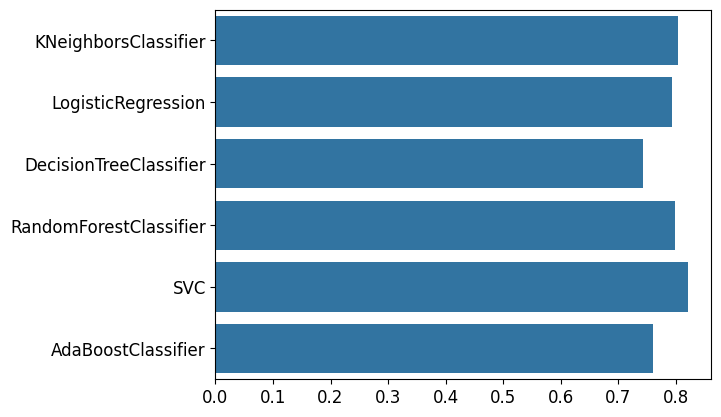

In [65]:
# 通过可视化判断最佳模型
plt.rcParams['font.size'] = 12
sns.barplot(y=classifier, x=score)

# 6.模型调参
可以看出，针对泰坦尼克这份数据集，svm和随机森林效果表现相对较好

In [66]:
# 选择svm模型继续优化---缩小参数范围

pipe = make_pipeline(StandardScaler(), SVC())
param_grids = {
    'svc__C':np.linspace(0.5, 2, 10),
    'svc__gamma':np.linspace(0.01, 0.2, 20)
}
gridcv = GridSearchCV(estimator=pipe, param_grid=param_grids, cv=5).fit(X_train, y_train)
score = gridcv.score(X_test, y_test)
print('Best param:', gridcv.best_params_)
print('SVC Score:', score.mean())

# Best param: {'svc__C': 1, 'svc__gamma': 0.1}
# SVC Score: 0.8268156424581006

Best param: {'svc__C': 0.5, 'svc__gamma': 0.08}
SVC Score: 0.8212290502793296


In [67]:
# 选择随机森林进行继续优化

param_grids = {
    'n_estimators':[1000],
    'max_features':range(10, 15)
}
gridcv = GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1), 
                      param_grid=param_grids, cv=5)
gridcv.fit(X_train, y_train)

train_score = gridcv.score(X_train, y_train)
test_score = gridcv.score(X_test, y_test)

print('Best param:', gridcv.best_params_)
print('Train Score:{}  Test Score:{}'.format(train_score, test_score))

Best param: {'max_features': 13, 'n_estimators': 1000}
Train Score:0.9845505617977528  Test Score:0.8044692737430168


# 7.模型分析
通过对参数的精确调整，我们有理由相信svm有更好的泛化效果，我们可以选择svm模型进行predict

# 8.模型应用

In [68]:
# 模型保存
# model.save('D:/desktop/model.model')

# 模型应用
# model.predit()